In [1]:
import os
os.chdir('/home/berling/reduce_opto_response/')
from neurostim.analysis import quick_sim_setup
import numpy as np
import pandas as pd
from neuron import h
from article_figures.article_plot_functions import plot_morphology_with_light, spatial_activation_plot, map_patt_id_2_xy, label_subplots_ABC
import matplotlib.pyplot as plt

--No graphics will be displayed.



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.6.0
 Built: Jan  9 2025 17:16:28

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.

Ca_HVA: gbar_Ca_HVA_somatic = 374.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_axonal = 306.0 uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_basal = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_HVA: gbar_Ca_HVA_apical = None uS/cm^2, e_Ca_HVA = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_somatic = 778.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_axonal = 50.0 uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_basal = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ca_LVAst: gbar_Ca_LVAst_apical = None uS/cm^2, e_Ca_LVAst = 132.4579341637009 mV
Ih: gbar_Ih_somatic = 80.0 uS/cm^2, e_Ih = 

/home/berling/reduce_opto_response/article_figures/article_plot_functions.py:33: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/berling/reduce_opto_response/article_figures/article_plot_functions.py:34: SettingWithCopyWarning:
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


APCmax:  10
APCmax:  1


Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


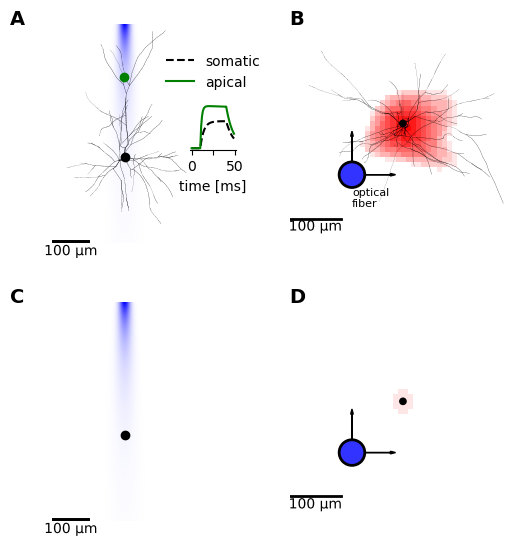

In [2]:
# Define cell and stimulator
simcontrol = quick_sim_setup(
    cell_dict = dict(
        cellmodel="L23_PC_cADpyr229_1",
        ChR_soma_density=13e9,
        ChR_distribution='uniform'),
    stimulator_dict = dict(
        diameter_um=50,
        NA=0.1),
)
# Define recording variables
rec_vars = [[],[]]
# Append time and soma voltage recoding
rec_vars[0].append('time [ms]')
rec_vars[1].append(h._ref_t)
rec_vars[0].append('g_soma')
rec_vars[1].append(simcontrol.cell.model.soma_sec(0.5)._ref_gcat_chanrhod)
rec_vars[0].append('g_apical')
apical_sec = simcontrol.cell.sections[1000]
rec_vars[1].append(apical_sec(0.5)._ref_gcat_chanrhod)
# Run simulation
tmp = simcontrol.run(
    temp_protocol=dict(
        duration_ms=30,
        delay_ms=10,
        total_rec_time_ms=50),
    stim_location=(0, 0, 0),
    stim_intensity_mWPERmm2=1,
    rec_vars=rec_vars,
    interpol_dt_ms=1
)

# calculate light profile
soma_depth = 423.3559875488281 # copy from printed info at cell initialization
n=2000
xs = np.linspace(-300,300, n)
zs = np.linspace(0,-800, n)
xx, zz = np.meshgrid(xs, zs)
I = simcontrol.stimulator.calculate_Tx_at_pos(pos_xyz_um=[xx,np.zeros(xx.shape),zz], stim_xyz_um=[0,0,0])

# load pre-simulated spatial activation maps
df = pd.read_csv('snake_workflow/result.csv', index_col='Unnamed: 0')
df_full = df.loc[(df.simtype=='full')]
df_point = pd.read_csv('article_figures/APC_soma_only_L23_PC_cADpyr229_1_cond_scale1.csv', index_col='Unnamed: 0')
# map x,y coordinates on light pattern ids
df_full, df_point = [
    map_patt_id_2_xy(df=df, xy_max=110, dxy=10, rotate=False) for df in [df_full, df_point]
]
# select light intensity (mW/mm2) and colorbar max for maps
light_int = 0.0004
APCmax=10
df_full, df_point = [
    df.loc[df.norm_power_mW_of_MultiStimulator==light_int] for df in [df_full, df_point]
]

############### Plotting
# figure format
a4_w = 8.27
a4_l = 11.7
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(0.8*a4_w,0.8*a4_w))
axs = axs.flatten()

# upper left
ax, light_prof_mappable = plot_morphology_with_light(
    ax=axs[0], 
    simtree=simcontrol.cell.sim_tree, 
    marklocs=[{'node': 1, 'x': 0.50 }, {'node': 4665, 'x': 0.50 }], 
    locargs=[dict(marker='o', mec='black', mfc='black'),dict(marker='o', mec='g', mfc='g')],
    morph_lw=0.5,
    light_prof_xx_zz_I=[xx,zz+soma_depth,I], 
    inset=True, inset_data=tmp
)
# lower left
ax, light_prof_mappable = plot_morphology_with_light(
    ax=axs[2], 
    simtree=simcontrol.cell.sim_tree, 
    marklocs=[{'node': 1, 'x': 0.50 }],
    locargs=[dict(marker='o', mec='black', mfc='black')],
    morph_lw=0,
    light_prof_xx_zz_I=[xx,zz+soma_depth,I], 
    inset=False, inset_data=None
)

# rotate cell to get topview simtree:
for node in simcontrol.cell.sim_tree:
        x, y, z = node.xyz
        node.xyz = [x, -1*z, y]
# upper right
ax, activation_mappable = spatial_activation_plot(
    ax=axs[1],
    df=df_full,
    APCmax=APCmax,
    cell_topview_simtree = simcontrol.cell.sim_tree,
    morph_lw=0.5,
    shift_x=0,
    label_fiber=True
)
# lower right
ax, activation_mappable = spatial_activation_plot(
    ax=axs[3],
    df=df_point,
    APCmax=APCmax,
    cell_topview_simtree = simcontrol.cell.sim_tree,
    morph_lw=0,
    shift_x=-5
)
label_subplots_ABC(fig, axs=axs, x_shift=0, y_shift=-0.02, fontsize=14, weight='bold')
fig.savefig('article_figures/figures/article_figure1.png', dpi=300)